In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset
import scipy.stats as stats
from IPython import display
display.set_matplotlib_formats('retina')


<ipython-input-1-3938795160>:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('retina')


In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')
data = data[data['total sulfur dioxide']<200]

cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('quality')
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)
data['boolQuality'] = 0
data.loc[data['quality'] > 5, 'boolQuality'] = 1
data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,boolQuality
0,-0.528350,0.960657,-1.391823,-0.452579,-0.244648,-0.464558,-0.382535,0.556807,1.288470,-0.580216,-0.959307,5,0
1,-0.298673,1.966614,-1.391823,0.049020,0.222827,0.877032,0.654661,0.025923,-0.723652,0.127837,-0.583341,5,0
2,-0.298673,1.295976,-1.185980,-0.165951,0.095334,-0.081247,0.246069,0.132100,-0.334209,-0.049176,-0.583341,5,0
3,1.653579,-1.386577,1.489975,-0.452579,-0.265897,0.110409,0.434650,0.662984,-0.983280,-0.462207,-0.583341,6,1
4,-0.528350,0.960657,-1.391823,-0.452579,-0.244648,-0.464558,-0.382535,0.556807,1.288470,-0.580216,-0.959307,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1594,-1.217380,0.401792,-0.980138,-0.380922,0.052836,1.547828,-0.068233,-0.982759,0.899027,-0.462207,0.074599,5,0
1595,-1.389638,0.122359,-0.877216,-0.237608,-0.542132,2.218623,0.151778,-0.865964,1.353377,0.599872,0.732539,6,1
1596,-1.159961,-0.101187,-0.722834,-0.165951,-0.244648,1.260344,-0.193954,-0.536815,0.704305,0.540868,0.544556,6,1
1597,-1.389638,0.653281,-0.774295,-0.380922,-0.265897,1.547828,-0.068233,-0.680154,1.677912,0.304850,-0.207376,5,0


In [3]:
dataT = torch.tensor(data[cols2zscore].values).float()
labels = torch.tensor(data['boolQuality'].values).float()
labels = labels[:,None]

In [4]:
train_data,test_data,train_labels,test_labels = train_test_split(dataT,labels,test_size=.1)
train_dataDataset = TensorDataset(train_data,train_labels)
test_dataDataset = TensorDataset(test_data,test_labels)
train_loader = DataLoader(train_dataDataset,batch_size=32, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataDataset,batch_size = test_dataDataset.tensors[0].shape[0])


In [5]:
class ANNwine_withBNorm(nn.Module):
  def __init__(self):
    super().__init__()
    self.input = nn.Linear(11,16)
    self.fc1 = nn.Linear(16,32)
    self.bnorm1 = nn.BatchNorm1d(16)
    self.fc2 = nn.Linear(32,20)
    self.bnorm2 = nn.BatchNorm1d(32)
    self.output = nn.Linear(20,1)
  def forward(self,x,doBN):
    x = F.relu(self.input(x))
    if doBN:
      x = self.bnorm1(x)
      x = self.fc1(x)
      x = F.relu(x)
      x = self.bnorm2(x)
      x = self.fc2(x)
      x = F.relu(x)
    else:
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
    return self.output(x)

In [12]:
numepochs = 1000
def trainTheModel(doBN = True):
  lossfun = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.SGD(winenet.parameters(),lr=.01)
  losses = torch.zeros(numepochs)
  trainAcc = []
  testAcc = []
  for epochi in range(numepochs):
    winenet.train()
    batchAcc = []
    batchLoss = []
    for X,y in train_loader:
      yHat = winenet(X,doBN)
      loss = lossfun(yHat,y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      batchLoss.append(loss.item())
      batchAcc.append(100*torch.mean(((yHat>0)==y).float()).item())
    trainAcc.append(np.mean(batchAcc))
    losses[epochi] = np.mean(batchLoss)
    winenet.eval()
    X,y = next(iter(test_loader))
    with torch.no_grad():
      yHat = winenet(X,doBN)
    testAcc.append(100*torch.mean(((yHat>0)==y).float()).item())
  return trainAcc,testAcc,losses

In [13]:
winenet = ANNwine_withBNorm()
trainAccNo,testAccNo,lossesNo = trainTheModel(False)
winenet = ANNwine_withBNorm()
trainAccWith,testAccWith,lossesWith = trainTheModel(True)

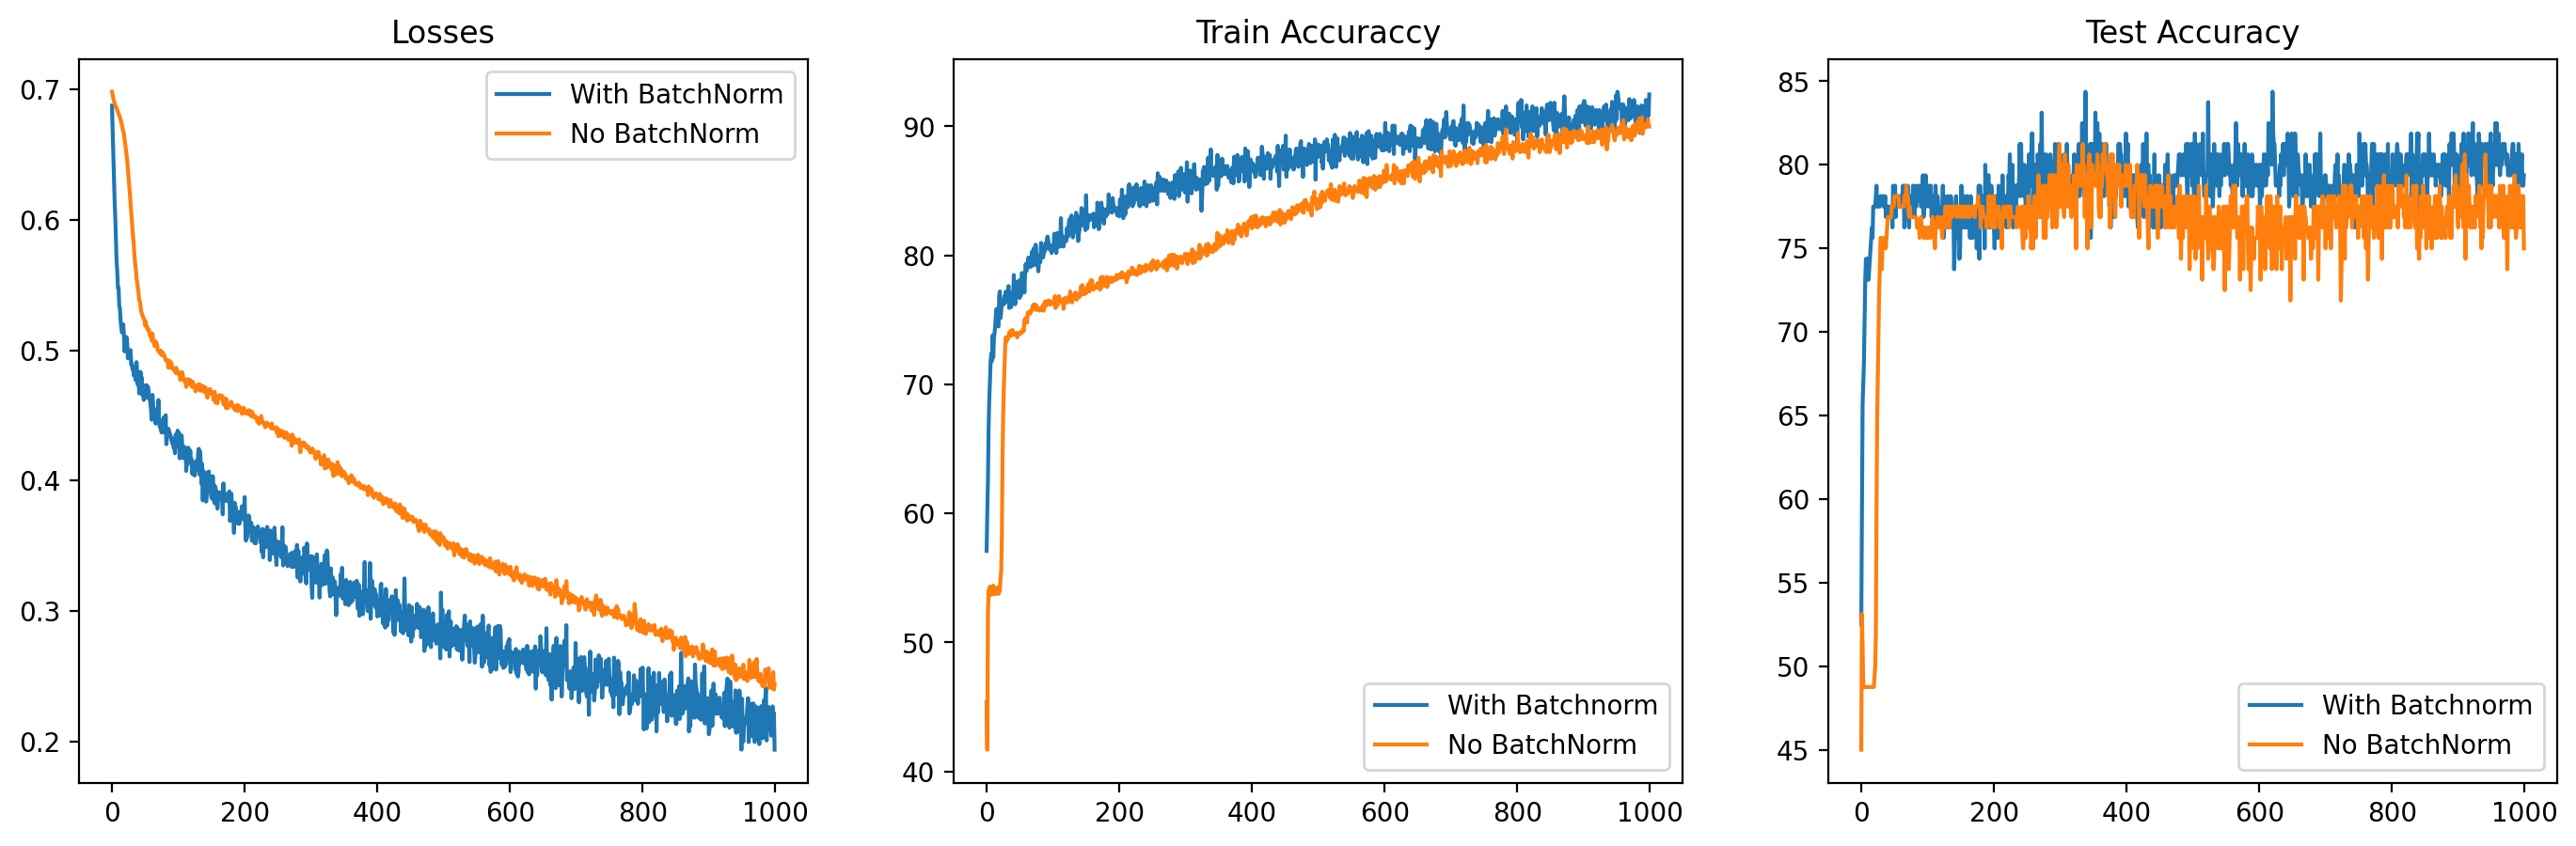

In [15]:
fig,ax = plt.subplots(1,3,figsize=(17,5))
ax[0].plot(lossesWith,label='With BatchNorm')
ax[0].plot(lossesNo,label='No BatchNorm')
ax[0].set_title('Losses')
ax[0].legend()

ax[1].plot(trainAccWith,label='With Batchnorm')
ax[1].plot(trainAccNo,label='No BatchNorm')
ax[1].set_title('Train Accuraccy')
ax[1].legend()

ax[2].plot(testAccWith,label='With Batchnorm')
ax[2].plot(testAccNo,label='No BatchNorm')
ax[2].set_title('Test Accuracy')
ax[2].legend()